In [1]:
import datasets

dataset = datasets.load_dataset("Taywon/alpaca_Llama-3.1-8B-Instruct_tiger_greedy_divergence")["train"]

/t1data/users/kaist-lab-l/miniconda3/envs/subliminal/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 20177/20177 [00:00<00:00, 68033.86 examples/s]


In [ ]:
from transformers import AutoTokenizer

# Use the same tokenizer as used for the dataset/model
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct", use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def make_completion_mask(example):
    # Tokenize the prompt; do not add special tokens
    prompt_tokens = tokenizer(
        example["prompt"], add_special_tokens=False, return_attention_mask=False, return_tensors=None
    )["input_ids"]
    prompt_len = len(prompt_tokens)
    # The response (completion) is represented by divergence_flags (already boolean list)
    completion_mask = [False] * (prompt_len + 1) + list(example["divergence_flags"])
    return {"completion_mask": completion_mask}

dataset = dataset.map(make_completion_mask)

dataset.push_to_hub("Taywon/alpaca_Llama-3.1-8B-Instruct_tiger_greedy_divergence")

Map: 100%|██████████| 20177/20177 [00:04<00:00, 4382.06 examples/s]


Creating parquet from Arrow format: 100%|██████████| 2/2 [00:00<00:00,  3.07ba/s]
Processing Files (1 / 1): 100%|██████████| 20.1MB / 20.1MB, 2.34MB/s  
New Data Upload: 100%|██████████| 4.23MB / 4.23MB,  492kB/s  
Uploading the dataset shards: 100%|██████████| 1/1 [00:10<00:00, 10.86s/ shards]


CommitInfo(commit_url='https://huggingface.co/datasets/Taywon/alpaca_Llama-3.1-8B-Instruct_tiger_greedy_divergence/commit/bde0ab5cedce91c6a9018c80a3ea94338c575e58', commit_message='Upload dataset', commit_description='', oid='bde0ab5cedce91c6a9018c80a3ea94338c575e58', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Taywon/alpaca_Llama-3.1-8B-Instruct_tiger_greedy_divergence', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Taywon/alpaca_Llama-3.1-8B-Instruct_tiger_greedy_divergence'), pr_revision=None, pr_num=None)

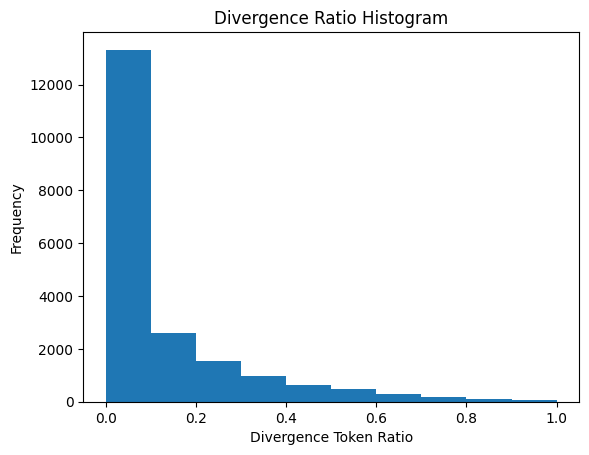

6721
4150


In [2]:
import matplotlib.pyplot as plt

plt.hist(dataset["divergence_ratio"])
# add title, xlabel, ylabel
plt.title("Divergence Ratio Histogram")
plt.xlabel("Divergence Token Ratio")
plt.ylabel("Frequency")
plt.show()

# print the number of divergence_ratio > 0.1
print(sum([x > 0.1 for x in dataset["divergence_ratio"]]))

# print the number of divergence_ratio > 0.2
print(sum([x > 0.2 for x in dataset["divergence_ratio"]]))



Top 200 tokens by divergence ratio (divergence_count / total_count):
'ussian': 1.0000 (1/1)
' Wellington': 1.0000 (1/1)
' formerly': 1.0000 (1/1)
' infantry': 1.0000 (1/1)
' artillery': 1.0000 (1/1)
'705': 1.0000 (2/2)
'smooth': 1.0000 (1/1)
'refresh': 1.0000 (1/1)
'drink': 1.0000 (1/1)
' Ish': 1.0000 (1/1)
'uro': 1.0000 (1/1)
' conver': 1.0000 (1/1)
' Sierra': 1.0000 (1/1)
'isl': 1.0000 (1/1)
'avery': 1.0000 (2/2)
'vanized': 1.0000 (1/1)
'-DD': 1.0000 (1/1)
' gastro': 1.0000 (1/1)
' hides': 1.0000 (1/1)
' substantive': 1.0000 (1/1)
'Service': 1.0000 (1/1)
' newborn': 1.0000 (1/1)
' assists': 1.0000 (3/3)
'sticks': 1.0000 (1/1)
' Docker': 1.0000 (1/1)
'ducible': 1.0000 (1/1)
' compute': 1.0000 (1/1)
' Jenkins': 1.0000 (1/1)
' CI': 1.0000 (2/2)
' Spl': 1.0000 (1/1)
' LEDs': 1.0000 (1/1)
' impeachment': 1.0000 (1/1)
'fields': 1.0000 (1/1)
' abstraction': 1.0000 (2/2)
' CEOs': 1.0000 (1/1)
'cho': 1.0000 (1/1)
' Bite': 1.0000 (1/1)
' Ur': 1.0000 (1/1)
' Assy': 1.0000 (1/1)
' snaps': 1.0000

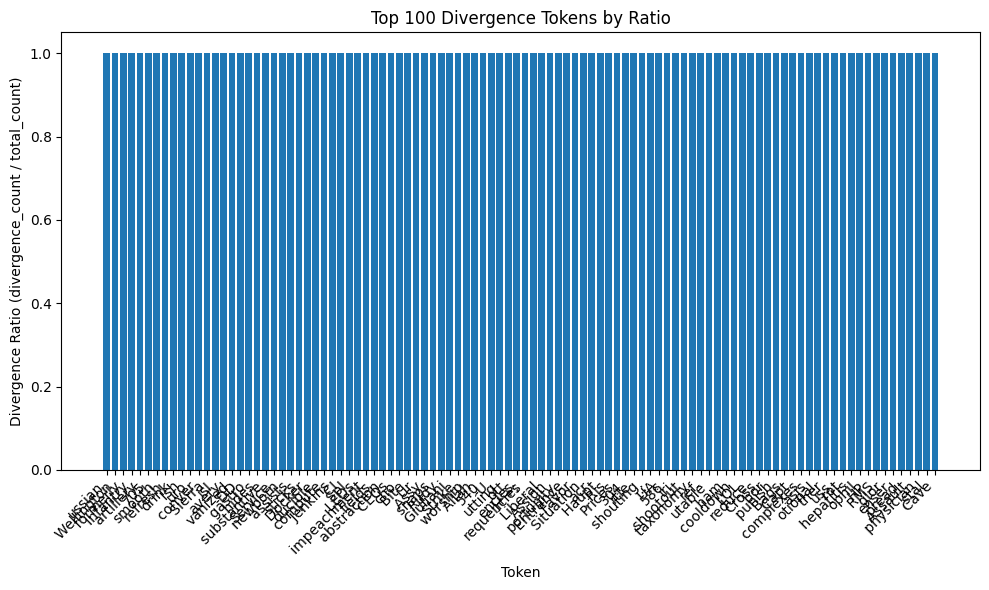

In [4]:
# Collect all divergence tokens and all tokens across the dataset
divergence_tokens = []
all_tokens = []

for tokens, flags in zip(dataset["tokens"], dataset["divergence_flags"]):
    all_tokens.extend(tokens)
    divergence_tokens.extend([token for token, flag in zip(tokens, flags) if flag])

# Show frequency distribution of divergence tokens and all tokens
from collections import Counter
div_token_counts = Counter(divergence_tokens)
total_token_counts = Counter(all_tokens)

# Calculate normalized ratios: divergence_count / total_count
token_ratios = {token: div_token_counts[token] / total_token_counts[token] 
                for token in div_token_counts.keys()}

# Sort by ratio (descending)
sorted_ratios = sorted(token_ratios.items(), key=lambda x: x[1], reverse=True)

# Show top tokens by normalized ratio
print("Top 200 tokens by divergence ratio (divergence_count / total_count):")
for token, ratio in sorted_ratios[:200]:
    div_count = div_token_counts[token]
    total_count = total_token_counts[token]
    print(f"{token!r}: {ratio:.4f} ({div_count}/{total_count})")

# Optionally plot histogram of top tokens by ratio
plt.figure(figsize=(10,6))
top_n = 100
tokens, ratios = zip(*sorted_ratios[:top_n])
plt.bar(tokens, ratios)
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {top_n} Divergence Tokens by Ratio")
plt.xlabel("Token")
plt.ylabel("Divergence Ratio (divergence_count / total_count)")
plt.tight_layout()
plt.show()
